In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json
import gc

from scipy.stats import uniform

import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVR, LinearSVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [ ]:
def load_csv(csv_path, nrows=None, skiprows=None):
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     converters = {col: json.loads for col in json_cols},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows,
                     skiprows=skiprows)
    
    for col in json_cols:
        normalized_col_df = pd.json_normalize(df[col])
        df = pd.concat([df.drop(columns=col), normalized_col_df], axis=1)
    return df

In [ ]:
train_df = load_csv('/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=120_000)

In [ ]:
def clean_up(df, train=False, valid=False):
    if train or valid:
        df = df.drop(columns='transactionRevenue') # This field is deprecated. Use "totals.totalTransactionRevenue" instead
        df["totalTransactionRevenue"] = df['totalTransactionRevenue'].fillna("0").astype(float)
    
    df["pageviews"] = df["pageviews"].fillna(0).astype(int)
    df["newVisits"] = df["newVisits"].fillna(0).astype(int)
    df["sessionQualityDim"] = df["sessionQualityDim"].fillna("1").astype(int)
    return df

train_df = clean_up(train_df, train=True)

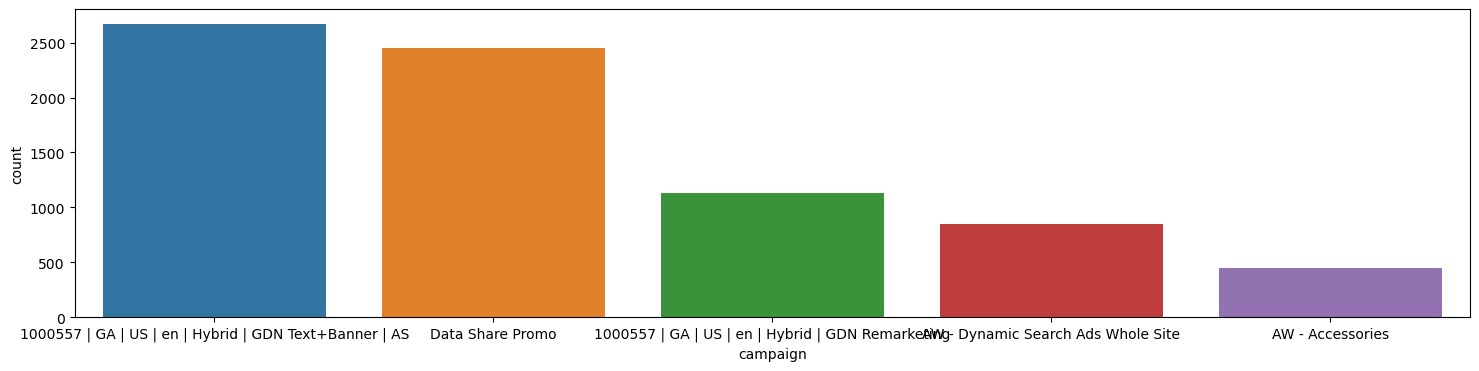

In [ ]:
country_counts = train_df[["campaign"]].groupby("campaign").size().sort_values(ascending=False)[1:6]
country_counts = country_counts.reset_index()
country_counts.columns = ["campaign", "count"]

plt.figure(figsize=(18,4))
sns.barplot(data=country_counts, x="campaign", y="count")
plt.show()

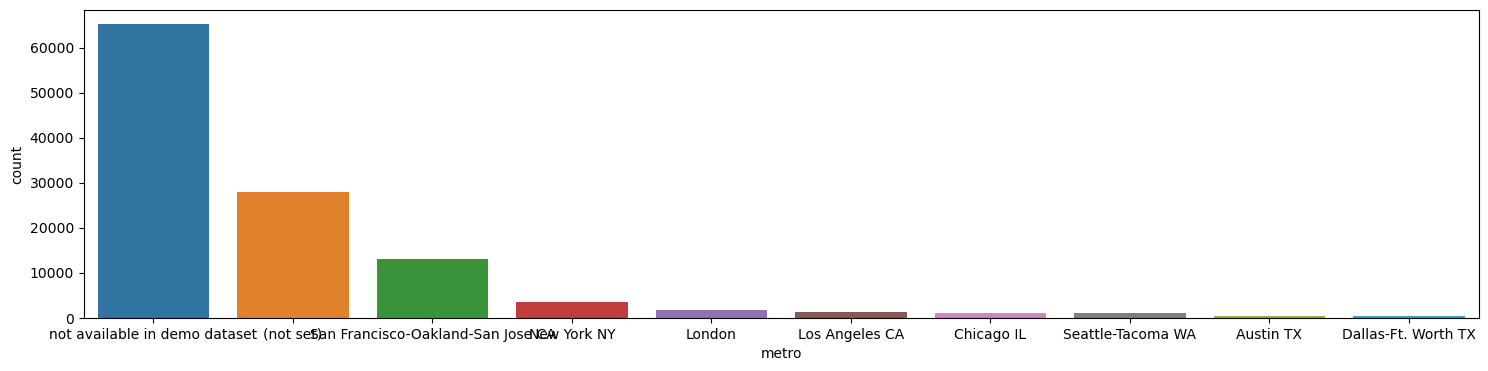

In [ ]:
country_counts = train_df[["metro"]].groupby("metro").size().sort_values(ascending=False)[:10]
country_counts = country_counts.reset_index()
country_counts.columns = ["metro", "count"]

plt.figure(figsize=(18,4))
sns.barplot(data=country_counts, x="metro", y="count")
plt.show()

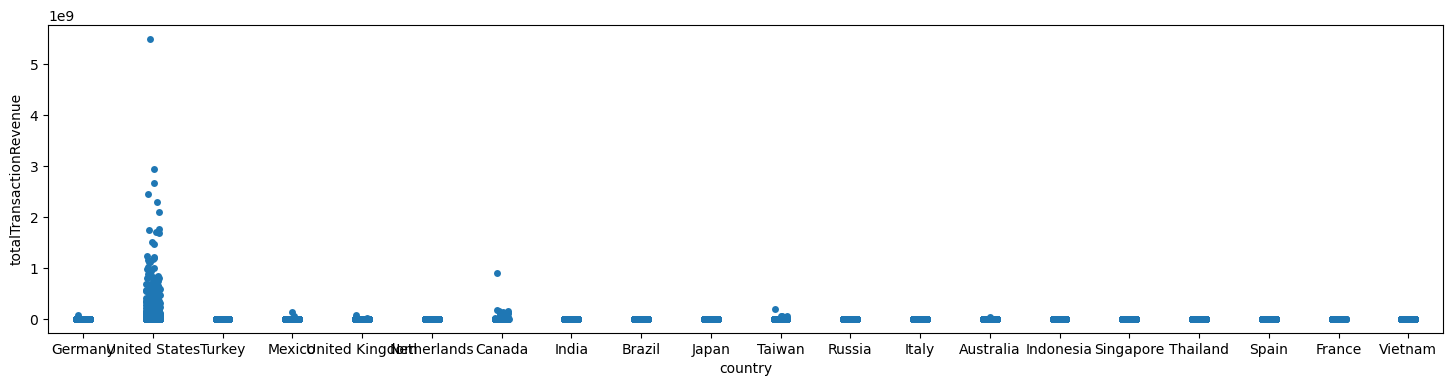

In [ ]:
top_countries = train_df[["country"]].groupby("country").size().sort_values(ascending=False)[:20].index.to_numpy()
train_df_top_countries = train_df[train_df["country"].isin(top_countries)]

plt.figure(figsize=(18,4))
sns.stripplot(data=train_df_top_countries, x="country", y="totalTransactionRevenue")
plt.show()

In [ ]:
def feature_extraction(df):
    agg_df = df.groupby("fullVisitorId")["newVisits", "pageviews"].agg(
        newVisits_sum = ("newVisits", "sum"),
        pageviews_sum = ("pageviews", "sum"),
        pageviews_mean = ("pageviews", "mean"),
        pageviews_std = ("pageviews", "std"),
    ).reset_index()
    agg_df["pageviews_std"] = agg_df["pageviews_std"].fillna(0)
    df = pd.merge(df, agg_df, on="fullVisitorId", suffixes=("", ""))
    return df

train_df = feature_extraction(train_df)

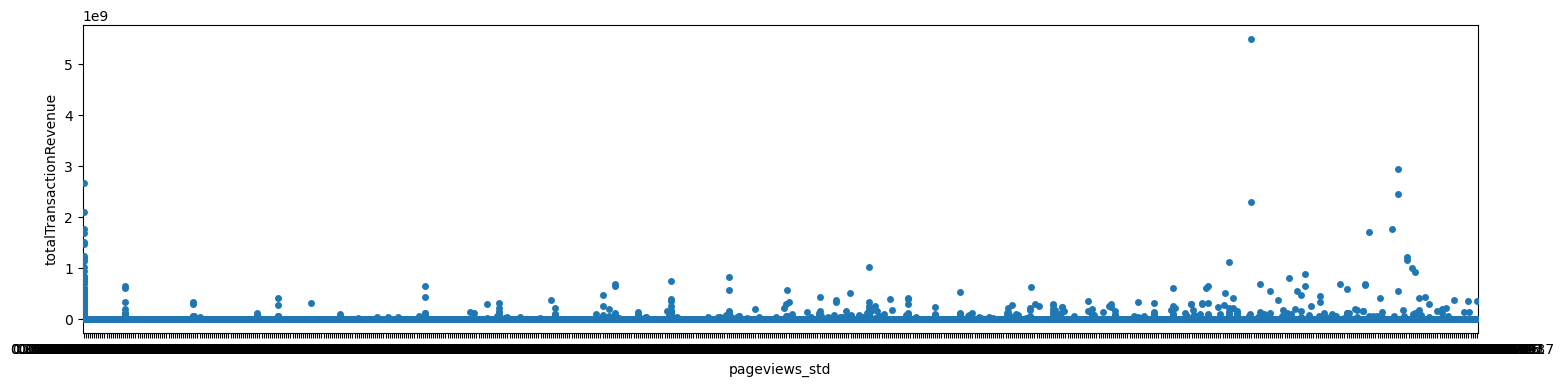

In [ ]:
plt.figure(figsize=(18,4))
sns.stripplot(data=train_df, x="pageviews_std", y="totalTransactionRevenue")
plt.show()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 119999
Data columns (total 63 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   channelGrouping                      120000 non-null  object 
 1   customDimensions                     120000 non-null  object 
 2   date                                 120000 non-null  int64  
 3   fullVisitorId                        120000 non-null  object 
 4   hits                                 120000 non-null  object 
 5   socialEngagementType                 120000 non-null  object 
 6   visitId                              120000 non-null  int64  
 7   visitNumber                          120000 non-null  int64  
 8   visitStartTime                       120000 non-null  int64  
 9   browser                              120000 non-null  object 
 10  browserVersion                       120000 non-null  object 
 11  browserSize  

In [ ]:
X = train_df.drop(columns="totalTransactionRevenue")
y = train_df["totalTransactionRevenue"].astype(float)

print(X.shape, y.shape)

(120000, 62) (120000,)


In [ ]:
# initialize with training dataset, apply it on test set as well
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
pca = PCA(n_components=24)
def get_features(df, train=False):
    df = df[["pageviews",
             "isMobile",
             "channelGrouping",
             "country",
             "metro",
             "newVisits_sum"
            ]]
    
    cat_cols = ["channelGrouping", "country", "metro"]
    if train:
        encoded_df = one_hot_encoder.fit_transform(df[cat_cols]).toarray()
        encoded_df = pca.fit_transform(encoded_df)
    else:
        encoded_df = one_hot_encoder.transform(df[cat_cols]).toarray()
        encoded_df = pca.transform(encoded_df)
    
    encoded_df = pd.DataFrame(encoded_df, index=df.index) # columns=pca.get_feature_names_out(),
    df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)
    
    return df

In [ ]:
def load_valid_df():
    val_df = load_csv('/kaggle/input/ga-customer-revenue-prediction/train_v2.csv',
                      nrows=60000, skiprows=range(1, 120000))
    val_df = clean_up(val_df, valid=True)
    val_df = feature_extraction(val_df)
    
    X_valid = val_df.drop(columns="totalTransactionRevenue")
    y_valid = val_df["totalTransactionRevenue"]
    
    return X_valid, y_valid

In [ ]:
X_train = get_features(X, train=True)
print(X_train.shape)

(120000, 27)


In [ ]:
%%time

# {'epsilon': 0.75, 'C': 2}
# dual=False, loss='squared_epsilon_insensitive'
model = LinearSVR(epsilon=0.75)
# distributions = dict(C=[0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4],
#                      epsilon=[0, 0.25, 0.5, 0.75, 1])
# clf = RandomizedSearchCV(model, distributions, random_state=0)
# clf.fit(X_train, y)
# print(clf.best_params_)

model.fit(X_train, y)

CPU times: user 415 ms, sys: 34.9 ms, total: 450 ms
Wall time: 451 ms


LinearSVR(epsilon=0.75)

In [ ]:
%%time

def valid_score(model):
    X_valid, y_valid = load_valid_df()
    
    result_valid = X_valid[["fullVisitorId"]]
    result_valid["Revenue"] = y_valid
    result_valid = result_valid.groupby("fullVisitorId").sum().reset_index()
    result_valid["Log_Revenue"] = np.log(result_valid["Revenue"] + 1)
    
    X_valid_features = get_features(X_valid)
    predictions_valid = model.predict(X_valid_features)
#     predictions_valid[predictions_valid < 0] = 0
    
    submission_valid = X_valid[["fullVisitorId"]]
    submission_valid["Predicted_Revenue"] = predictions_valid
    submission_valid = submission_valid.groupby("fullVisitorId").sum().reset_index()
    submission_valid["Log_Predicted_Revenue"] = np.log(submission_valid["Predicted_Revenue"] + 1)
    
    rmse = np.sqrt(mean_squared_error(result_valid["Log_Revenue"], submission_valid["Log_Predicted_Revenue"]))
    return rmse

# print("validation score: ", valid_score(model))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [ ]:
del train_df
del X
del y
del X_train
gc.collect()

260

In [ ]:
test_df = load_csv('/kaggle/input/ga-customer-revenue-prediction/test_v2.csv')
test_df = clean_up(test_df)
test_df = feature_extraction(test_df)

print(test_df.shape)

(401589, 63)


In [ ]:
%%time

X_test = get_features(test_df)
predictions = model.predict(X_test)
# predictions[predictions < 0] = 0
predictions

CPU times: user 5.63 s, sys: 3.32 s, total: 8.96 s
Wall time: 7.01 s


array([-1.21981841, -1.09965017, -1.1580207 , ..., -0.87136691,
       -1.23936129, -0.93995445])

In [ ]:
print(X_test.columns)

Index([    'pageviews',      'isMobile', 'newVisits_sum',               0,
                     1,               2,               3,               4,
                     5,               6,               7,               8,
                     9,              10,              11,              12,
                    13,              14,              15,              16,
                    17,              18,              19,              20,
                    21,              22,              23],
      dtype='object')


In [ ]:
submission = test_df[["fullVisitorId"]]
submission["PredictedLogRevenue"] = np.log(predictions + 1)
submission = submission.groupby('fullVisitorId').sum().reset_index()
submission.head(5)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000000
1,0000039738481224681,-0.691222
2,0000073585230191399,-1.165698
3,0000087588448856385,-1.088970
4,0000149787903119437,-2.178522


In [ ]:
submission.to_csv('submission.csv', index = False)

In [ ]:
del test_df
del X_test
del submission
gc.collect()

42